In [7]:
import pandas as pd
import numpy as np
import tqdm
from tqdm import tqdm_notebook
import difflib
import sys
import re
from matplotlib import pyplot as plt
import matplotlib

import ast
import string
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem import SnowballStemmer 
from nltk.corpus import stopwords
from nltk import collocations

from pymystem3 import Mystem
YStem = Mystem()

%pylab inline

from sklearn.ensemble import GradientBoostingClassifier

import scipy
from scipy import spatial

Populating the interactive namespace from numpy and matplotlib


In [2]:
trains, tests = pd.read_csv("train_tokens_facts_number.csv"), pd.read_csv("test_tokens_facts_number.csv")

In [3]:
# df - train dataset;
# variable = переменная
# variable_title - название переменной на графике
def PlotHistByTarget(variable, variable_title, min_x, max_x, df, df_title): 
    print('Histogram for '+variable_title)
    
    print(DescStatsByTarget(variable, variable_title, df, df_title))
    
    plt.style.use('seaborn-deep')
    
    if df_title == 'train':
        hist_df = pd.DataFrame({'target':df['target'],variable_title:variable})
        pyplot.hist([hist_df[hist_df['target']==0][variable_title].values,hist_df[hist_df['target']==1][variable_title].values], 
                bins = 100, 
                alpha = 0.5, 
                label=['target: 0','target: 1'], 
                color = ['r','b'])
        plt.xlim(xmin=min_x, xmax = max_x)
        plt.legend()
        plt.show()
    else:
        hist_df = pd.DataFrame({variable_title:variable})
        pyplot.hist(hist_df[variable_title].values, 
                bins = 100, 
                alpha = 0.5, 
                label = 'test dataset',
                color = 'g')
        plt.xlim(xmin=min_x, xmax = max_x)
        plt.legend()
        plt.show()
        
    
def DescStatsByTarget(variable, variable_title, df, df_title):
    
    if df_title == 'train':
        dft = pd.DataFrame({'target':df['target'],variable_title:variable})

        x = dft[dft['target']==0][variable_title].values
        dfx = pd.DataFrame({'target: 0':x})

        count0 = len(x)
        mean0 = round(np.mean(x),6)
        std0 = round(np.std(x),6)
        min0 = round(np.min(x),6)
        median0 = round(np.median(x),6)
        max0 = round(np.max(x),6)

        y = dft[dft['target']==1][variable_title].values
        dfy = pd.DataFrame({'target: 1':y})

        count1 = len(y)
        mean1 = round(np.mean(y),6)
        std1 = round(np.std(y),6)
        min1 = round(np.min(y),6)
        median1 = round(np.median(y),6)
        max1 = round(np.max(y),6)

        df_desc = pd.DataFrame([[count0, mean0, std0, min0, median0, max0],
                            [count1, mean1, std1, min1, median1, max1]],
                            columns = ['count','mean','std','min','median','max'], 
                            index=[variable_title+' (target: 0)',variable_title+' (target: 1)'])
    else:
        
        dft = pd.DataFrame({variable_title:variable})

        x = dft[variable_title].values
        
        count = len(x)
        mean = round(np.mean(x),6)
        std = round(np.std(x),6)
        min = round(np.min(x),6)
        median = round(np.median(x),6)
        max = round(np.max(x),6)

        df_desc = pd.DataFrame([[count, mean, std, min, median, max]],
                            columns = ['count','mean','std','min','median','max'], 
                            index=[variable_title+' (test)'])
    
    return df_desc

In [4]:
def uniq_words(text):
    return set(re.findall("\w+", text))

In [5]:
trains.head(1)

,paragraph,paragraph_id,question,question_id,target,train,tokens_paragraph,tokens_question,facts_paragraph,facts_question,cosine_distance,len_paragraph,len_question,len_intersection,len_intersection_rate,terms_paragraph,terms_question,terms_intersection,terms_intersection_rate
0,"В отличие от рыб, земноводные (амфибии) и прес...",1094,С какого года Русское Царство перешло на летои...,46273,0.0,1,"['в', 'отличие', 'от', 'рыба', 'земноводный', ...","['с', 'какой', 'год', 'русский', 'царство', 'п...","['сердце', 'четырёхкамерный сердце', 'рептилия...","['год', 'русский царство', 'какая год', '1 янв...",0.982397,64,19,4,0.210526,40,12,0,0.0


In [6]:
for name, df in [('train', trains), ('test', tests)]:
    df.set_value(0,'list_ratio',0)
    df.set_value(0,'list_intersections',0)
    df['list_ratio'] = df['list_ratio'].astype(object)
    df['list_intersections'] = df['list_intersections'].astype(object)
    for index, row in tqdm.tqdm_notebook(df.iterrows(), total=df.shape[0], desc="build features for " + name):
        sentences = row.paragraph.split('. ')
        question = row.question
        
        unq_question = uniq_words(row.question)
        
        list_ratio = []
        list_intersections = []
        
        for sentence in sentences:
            list_ratio.append(round(difflib.SequenceMatcher(None, sentence, question).ratio(),5))
            list_intersections.append(len(uniq_words(sentence) & unq_question))
        
        df.set_value(index, 'list_ratio', list_ratio)
        df.set_value(index, 'list_intersections', list_intersections)
        #df.loc[index, 'len_paragraph'] = len(uniq_words(row.paragraph))
        #df.loc[index, 'len_question'] = len(unq_question)
        #df.loc[index, 'len_intersection'] = len(uniq_words(row.paragraph) & unq_question)

In [30]:
trigram_measures = collocations.TrigramAssocMeasures()
finder = collocations.TrigramCollocationFinder.from_words(ast.literal_eval(trains.tokens_paragraph[0]), window_size=3)
finder.nbest(trigram_measures.pmi, 100)

[('всего', 'связать', 'с'),
 ('дальнейший', 'такой', 'строение'),
 ('два', 'круг', 'кровообращение'),
 ('к', 'полуводный', 'образ'),
 ('не', 'полностью', 'разделять'),
 ('они', 'трёхкамерный', 'появляться'),
 ('от', 'рыба', 'земноводный'),
 ('отличие', 'от', 'рыба'),
 ('переход', 'предок', 'к'),
 ('полностью', 'разделять', 'предсердие'),
 ('полуводный', 'образ', 'жизнь'),
 ('предок', 'к', 'полуводный'),
 ('рыба', 'земноводный', 'амфибия'),
 ('с', 'переход', 'предок'),
 ('связать', 'с', 'переход'),
 ('скорый', 'всего', 'связать'),
 ('снижение', 'активность', 'но'),
 ('трёхкамерный', 'появляться', 'межпредсердный'),
 ('активность', 'но', 'уже'),
 ('в', 'дальнейший', 'такой'),
 ('в', 'отличие', 'от'),
 ('или', 'гад', 'уже'),
 ('иметь', 'два', 'круг'),
 ('крокодил', 'считаться', 'что'),
 ('межпредсердиевый', 'перегородка', 'не'),
 ('межпредсердный', 'перегородка', 'единственный'),
 ('неполноценный', 'межпредсердиевый', 'перегородка'),
 ('перегородка', 'не', 'полностью'),
 ('потомок', 'дино

In [29]:
ast.literal_eval(trains.tokens_paragraph[0])

'в'

In [18]:
def get_tokens_bigrams(text):
    #tokens = nltk.word_tokenize(text)
    #tokens = [re.sub('\'','',i.lower()) for i in tokens if ( i not in string.punctuation+'—' )]
    #stop_words = stopwords.words('russian')
    #stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', 'к', 'на'])
    #tokens = [i for i in tokens if ( i not in stop_words )]
    bigram_measures = collocations.BigramAssocMeasures()
    finder = collocations.BigramCollocationFinder.from_words(text, window_size=2)
    return finder.nbest(bigram_measures.pmi, 100)

In [19]:
def get_tokens_trigrams(text):
    #tokens = nltk.word_tokenize(text)
    #tokens = [re.sub('\'','',i.lower()) for i in tokens if ( i not in string.punctuation+'—' )]
    #stop_words = stopwords.words('russian')
    #stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', 'к', 'на'])
    #tokens = [i for i in tokens if ( i not in stop_words )]
    trigram_measures = collocations.TrigramAssocMeasures()
    finder = collocations.TrigramCollocationFinder.from_words(text, window_size=3)
    return finder.nbest(trigram_measures.pmi, 100)

In [34]:
for name, df in [('train', trains), ('test', tests)]:
    for index, row in tqdm.tqdm_notebook(df.iterrows(), total=df.shape[0], desc="build features for " + name):
        df.loc[index, 'min_ratio'] = np.min(row.list_ratio)
        df.loc[index, 'max_ratio'] = np.max(row.list_ratio)
        df.loc[index, 'std_ratio'] = np.std(row.list_ratio)
        df.loc[index, 'mean_ratio'] = np.mean(row.list_ratio)
        df.loc[index, 'num_sentences'] = len(row.list_ratio)
        df.loc[index, 'min_inter'] = np.min(row.list_intersections)
        df.loc[index, 'max_inter'] = np.max(row.list_intersections)
        df.loc[index, 'std_inter'] = np.std(row.list_intersections)
        df.loc[index, 'mean_inter'] = np.mean(row.list_intersections)
        df.loc[index, 'unq_qwords_rate'] = len(set(ast.literal_eval(row.tokens_question)))/len(ast.literal_eval(row.tokens_question))
        df.loc[index, 'bigram_intersection'] = len(set(list(get_tokens_bigrams(ast.literal_eval(row.tokens_paragraph))))&set(list(get_tokens_bigrams(ast.literal_eval(row.tokens_question)))))
        df.loc[index, 'trigram_intersection'] = len(set(list(get_tokens_trigrams(ast.literal_eval(row.tokens_paragraph))))&set(list(get_tokens_trigrams(ast.literal_eval(row.tokens_question)))))

112/|/  0%|| 112/119398 [00:20<6:12:36,  5.34it/s]                                                                     



In [179]:
trains.to_csv("train_tokens_facts_number_BIG.csv", index=False, encoding ='utf-8')
tests.to_csv("test_tokens_facts_number_BIG.csv", index=False, encoding ='utf-8')

In [ ]:
trains, tests = pd.read_csv("train_tokens_facts_number_BIG.csv"), pd.read_csv("test_tokens_facts_number_BIG.csv")

In [180]:
trains.shape, tests.shape

((119398, 33), (74294, 34))

In [181]:
trains.columns

Index(['paragraph', 'paragraph_id', 'question', 'question_id', 'target',
       'train', 'tokens_paragraph', 'tokens_question', 'facts_paragraph',
       'facts_question', 'cosine_distance', 'len_paragraph', 'len_question',
       'len_intersection', 'len_intersection_rate', 'terms_paragraph',
       'terms_question', 'terms_intersection', 'terms_intersection_rate',
       'list_ratio', 'list_intersections', 'min_ratio', 'max_ratio',
       'std_ratio', 'mean_ratio', 'num_sentences', 'min_inter', 'max_inter',
       'std_inter', 'mean_inter', 'unq_qwords_rate', 'bigram_intersection',
       'trigram_intersection'],
      dtype='object')

In [182]:
tests.columns

Index(['paragraph', 'paragraph_id', 'question', 'question_id', 'target',
       'train', 'tokens_paragraph', 'tokens_question', 'facts_paragraph',
       'facts_question', 'cosine_distance', 'len_paragraph', 'len_question',
       'len_intersection', 'len_intersection_rate', 'terms_paragraph',
       'terms_question', 'terms_intersection', 'terms_intersection_rate',
       'list_ratio', 'list_intersections', 'min_ratio', 'max_ratio',
       'std_ratio', 'mean_ratio', 'num_sentences', 'min_inter', 'max_inter',
       'std_inter', 'mean_inter', 'unq_qwords_rate', 'bigram_intersection',
       'trigram_intersection', 'prediction'],
      dtype='object')

In [ ]:
trains, tests = pd.read_csv("train_tokens_facts_number_BIG.csv", encoding ='utf-8'), pd.read_csv("test_tokens_facts_number_BIG.csv", encoding ='utf-8')

In [65]:
for name, df in [('train', trains), ('test', tests)]:
    for index, row in tqdm.tqdm_notebook(df.iterrows(), total=df.shape[0], desc="build features for " + name):
        df.loc[index, 'unq_qwords_rate'] = len(set(ast.literal_eval(row.tokens_question)))/len(ast.literal_eval(row.tokens_question))

In [248]:
for name, df in [('train', trains), ('test', tests)]:
    for index, row in tqdm.tqdm_notebook(df.iterrows(), total = df.shape[0], desc = "Adding len% for "+ name):
        df.loc[index, 'len_percent'] =  round((len(set(ast.literal_eval(row.tokens_paragraph)+
            ast.literal_eval(row.tokens_question)))/
          len(set(ast.literal_eval(row.tokens_paragraph)))-1)*100,4)

In [314]:
for name, df in [('train', trains), ('test', tests)]:
    df.set_value(0,'list_len_percent',0)
    df['list_len_percent'] = df['list_len_percent'].astype(object)
    for index, row in tqdm.tqdm_notebook(df.iterrows(), total=df.shape[0], desc="sents len% list for " + name):
        sentences = sent_tokenize(trains.loc[index].paragraph) #row.paragraph.split('. ')

        list_len_percent = []
        
        for sentence in sentences:
            #if index< 10:
                #print(index,(len(set(sentence+row.question))),len(set(sentence)))
            #print(sentence)
            list_len_percent.append(round((len(set(sentence+row.question))/len(set(sentence))-1)*100,4))
            df.set_value(index, 'list_len_percent', list_len_percent)

In [315]:
for name, df in [('train', trains), ('test', tests)]:
    for index, row in tqdm.tqdm_notebook(df.iterrows(), total = df.shape[0], desc = "Adding pars len% for "+ name):
        df.loc[index, 'min_len_percent'] = np.min(row.list_len_percent)
        df.loc[index, 'max_len_percent'] = np.max(row.list_len_percent)
        df.loc[index, 'std_len_percent'] = np.std(row.list_len_percent)
        df.loc[index, 'mean_len_percent'] = np.mean(row.list_len_percent)

In [313]:
trains.head()

,paragraph,paragraph_id,question,question_id,target,train,tokens_paragraph,tokens_question,facts_paragraph,facts_question,...,num_sentences,min_inter,max_inter,std_inter,mean_inter,unq_qwords_rate,bigram_intersection,trigram_intersection,len_percent,list_len_percent
0,"В отличие от рыб, земноводные (амфибии) и прес...",1094,С какого года Русское Царство перешло на летои...,46273,0.0,1,"['в', 'отличие', 'от', 'рыба', 'земноводный', ...","['с', 'какой', 'год', 'русский', 'царство', 'п...","['сердце', 'четырёхкамерный сердце', 'рептилия...","['год', 'русский царство', 'какая год', '1 янв...",...,4.0,1.0,2.0,0.500000,1.500000,0.904762,0.0,0.0,23.4375,"[23.5294, 22.2222, 37.037, 41.3793]"
1,В 1049 году Балдуину V удалось отнять у Герман...,7414,Кто упомянул о его первых разногласиях со Штей...,19164,0.0,1,"['в', '1049', 'год', 'балдуин', 'v', 'удаться'...","['кто', 'упомянуть', 'о', 'он', 'один', 'разно...","['балдуин', 'сын', 'граф', 'фландрий', 'престо...","['подозрительный модернистский наклонность', '...",...,7.0,0.0,2.0,0.903508,0.571429,0.935484,0.0,0.0,32.0513,"[35.1351, 32.3529, 55.5556, 48.2759, 86.9565, ..."
2,Стремление достичь предельных значений ёмкости...,6744,Как называется имеющая мировое значение эпоха ...,39767,0.0,1,"['стремление', 'достигнуть', 'предельный', 'зн...","['как', 'называться', 'иметь', 'мировой', 'зна...","['страница', 'информация', 'блок', 'одиночный ...","['средний веко', 'новый время', 'мировая значе...",...,2.0,2.0,3.0,0.500000,2.500000,0.952381,0.0,0.0,25.8621,"[23.6842, 25.0]"
3,Первый практически пригодный двухтактный газов...,7300,Что усугублялось из-за международного давления...,36318,0.0,1,"['один', 'практически', 'пригодный', 'двухтакт...","['что', 'усугубляться', 'из', 'за', 'междунаро...","['двигатель', 'ленуар', 'электрический искрово...","['международный давление', 'чили', 'торговля',...",...,8.0,0.0,3.0,0.992157,0.625000,1.000000,0.0,0.0,17.7419,"[16.2162, 76.1905, 833.3333, 12.1212, 25.9259,..."
4,Требуя от художника углубленного изучения изоб...,7077,Какой характер носят пророчества Леонардо да В...,41534,0.0,1,"['требовать', 'от', 'художник', 'углублённый',...","['какой', 'характер', 'носить', 'пророчество',...","['книжка', 'запись', 'своеобразный интимный дн...","['какая характер', 'характер', 'пророчество', ...",...,5.0,0.0,3.0,1.200000,0.600000,1.000000,2.0,1.0,3.6145,"[10.0, 29.1667, 14.7059, 12.5, 16.6667]"


2780/|/  2%|| 2780/119398 [00:20<14:26, 134.56it/s]                                                                    

In [385]:
trains.loc[3].paragraph

'Первый практически пригодный двухтактный газовый ДВС был сконструирован французским механиком Этьеном Ленуаром в 1860 году. Мощность составляла 8,8 кВт (11,97 л. с.). Двигатель представлял собой одноцилиндровую горизонтальную машину двойного действия, работавшую на смеси воздуха и светильного газа с электрическим искровым зажиганием от постороннего источника. В конструкции двигателя появился кривошипно-шатунный механизм. КПД двигателя не превышал 4,65 %. Несмотря на недостатки, двигатель Ленуара получил некоторое распространение. Использовался как лодочный двигатель.'

In [351]:
from nltk.tokenize import sent_tokenize, word_tokenize

In [377]:
sent_tokenize(trains.loc[3].paragraph)

['Первый практически пригодный двухтактный газовый ДВС был сконструирован французским механиком Этьеном Ленуаром в 1860 году.',
 'Мощность составляла 8,8 кВт (11,97 л.',
 'с.).',
 'Двигатель представлял собой одноцилиндровую горизонтальную машину двойного действия, работавшую на смеси воздуха и светильного газа с электрическим искровым зажиганием от постороннего источника.',
 'В конструкции двигателя появился кривошипно-шатунный механизм.',
 'КПД двигателя не превышал 4,65 %.',
 'Несмотря на недостатки, двигатель Ленуара получил некоторое распространение.',
 'Использовался как лодочный двигатель.']

In [617]:
import pymorphy2 as pm
morph = pm.MorphAnalyzer()

morph.parse('')[0].normal_form

'десятилетие'

In [628]:
D_except = {'(': ' '
            ,')': ' '
            ,'[': ' '
            ,']': ' '
            ,'{': ' '
            ,'}': ' '
            ,'&': ' '
            ,'@': ' '
            ,'#': ' '
            ,'$': ' '
            ,'%': ' '
            ,'*': ' '
            ,'—': ' '
            #,'[^[0-9]+\,[0-9]+]': ' '
            ,'\u0301': ''
            ,';': ' '
            ,':': ' '
            #,'[.]': ' '
           }

[word_tokenize(morph.parse(t)[0].normal_form.replace('.','').replace(',','')) 
 for t in sent_tokenize(re.sub('.', lambda m: D_except.get(m.group(), m.group()), 
    ''.join(YStem.lemmatize(re.sub('([\(\[]).*?([\)\]])',' ',trains.loc[5174].paragraph)))))]

[['в',
  'течение',
  'десятилетие',
  'имя',
  'бунин',
  'часто',
  'упоминаться',
  'в',
  'разный',
  'контекст',
  'рядом',
  'с',
  'горький'],
 ['в',
  'их',
  'отношение',
  'исследователь',
  'выделять',
  'ряд',
  'ключевой',
  'стадия',
  'период',
  'постепенный',
  'сближение',
  'смениться',
  'время',
  'весьма',
  'плотный',
  'общение',
  'затем',
  'последовать',
  'разрыв',
  'с',
  'полный',
  'неприятие',
  'взгляд',
  'друг',
  'друг',
  'сопровождать',
  'публичный',
  'иногда',
  'очень',
  'жесткий',
  'оценка'],
 ['знакомство',
  'писатель',
  'происходить',
  'в',
  'ялта',
  'в',
  '1899',
  'год',
  'согласно',
  'мемуары',
  'бунин',
  'горький',
  'настроенный',
  'на',
  'сентиментальный',
  'лад',
  'при',
  'первый',
  'же',
  'встреча',
  'произносить',
  'вы',
  'же',
  'последний',
  'писатель',
  'от',
  'дворянство',
  'тот',
  'культура',
  'который',
  'давать',
  'мир',
  'пушкин',
  'и',
  'толстой'],
 ['через',
  'несколько',
  'день',
  'ива

In [636]:
train, test = pd.read_csv("train_task1_latest.csv"), pd.read_csv("test_task1_latest.csv")

In [639]:
D_except = {'(': ' '
            ,')': ' '
            ,'[': ' '
            ,']': ' '
            ,'{': ' '
            ,'}': ' '
            ,'&': ' '
            ,'@': ' '
            ,'#': ' '
            ,'$': ' '
            ,'%': ' '
            ,'*': ' '
            ,'—': ' '
            #,'[^[0-9]+\,[0-9]+]': ' '
            ,'\u0301': ''
            ,';': ' '
            ,':': ' '
            #,'[.]': ' '
           }

for name, df in [('train', train), ('test', test)]:
    df.set_value(0,'list_ntokens_p',0)
    df.set_value(0,'list_ntokens_q',0)
    df['list_ntokens_p'] = df['list_ntokens_p'].astype(object)
    df['list_ntokens_q'] = df['list_ntokens_q'].astype(object)
    for index, row in tqdm.tqdm_notebook(df.iterrows(), total=df.shape[0], desc="build norm tokens for " + name):
        df.set_value(index, 'list_ntokens_p', 
                     [word_tokenize(morph.parse(t)[0].normal_form.replace('.','').replace(',','')) 
                     for t in sent_tokenize(re.sub('.', lambda m: D_except.get(m.group(), m.group()), 
                     ''.join(YStem.lemmatize(re.sub('([\(\[]).*?([\)\]])',' ',row.paragraph)))))])
        df.set_value(index, 'list_ntokens_q', 
                     [word_tokenize(morph.parse(t)[0].normal_form.replace('.','').replace(',','')) 
                     for t in sent_tokenize(re.sub('.', lambda m: D_except.get(m.group(), m.group()), 
                     ''.join(YStem.lemmatize(re.sub('([\(\[]).*?([\)\]])',' ',row.question)))))])

KeyboardInterrupt: 

In [640]:
train.to_csv("train_Ynd_stemmer.csv", index=False, encoding = 'utf-8')
#test.to_csv("test_step1.csv", index=False, encoding = 'utf-8')

In [633]:
train.head()

,paragraph_id,question_id,paragraph,question,target,list_ntokens_p,list_ntokens_q
0,1094,46273,"В отличие от рыб, земноводные (амфибии) и прес...",С какого года Русское Царство перешло на летои...,0.0,"[[в, отличие, от, рыба, земноводный, и, пресмы...","[[с, какой, год, русский, царство, переходить,..."
1,7414,19164,В 1049 году Балдуину V удалось отнять у Герман...,Кто упомянул о его первых разногласиях со Штей...,0.0,"[[в, 1049, год, балдуин, v, удаваться, отнимат...","[[кто, упоминать, о, его, первый, разногласие,..."
2,6744,39767,Стремление достичь предельных значений ёмкости...,Как называется имеющая мировое значение эпоха ...,0.0,"[[стремление, достигать, предельный, значение,...","[[как, называться, иметь, мировой, значение, э..."
3,7300,36318,Первый практически пригодный двухтактный газов...,Что усугублялось из-за международного давления...,0.0,"[[первый, практически, пригодный, двухтактный,...","[[что, усугубляться, из-за, международный, дав..."
4,7077,41534,Требуя от художника углубленного изучения изоб...,Какой характер носят пророчества Леонардо да В...,0.0,NaN,NaN


In [627]:
upd_str

[['в',
  'течение',
  'десятилетие',
  'имя',
  'бунин',
  'часто',
  'упоминаться',
  'в',
  'разный',
  'контекст',
  'рядом',
  'с',
  'горький'],
 ['в',
  'их',
  'отношение',
  'исследователь',
  'выделять',
  'ряд',
  'ключевой',
  'стадия',
  'период',
  'постепенный',
  'сближение',
  'смениться',
  'время',
  'весьма',
  'плотный',
  'общение',
  'затем',
  'последовать',
  'разрыв',
  'с',
  'полный',
  'неприятие',
  'взгляд',
  'друг',
  'друг',
  'сопровождать',
  'публичный',
  'иногда',
  'очень',
  'жесткий',
  'оценка'],
 ['знакомство',
  'писатель',
  'происходить',
  'в',
  'ялта',
  'в',
  '1899',
  'год',
  'согласно',
  'мемуары',
  'бунин',
  'горький',
  'настроенный',
  'на',
  'сентиментальный',
  'лад',
  'при',
  'первый',
  'же',
  'встреча',
  'произносить',
  'вы',
  'же',
  'последний',
  'писатель',
  'от',
  'дворянство',
  'тот',
  'культура',
  'который',
  'давать',
  'мир',
  'пушкин',
  'и',
  'толстой'],
 ['через',
  'несколько',
  'день',
  'ива

In [621]:

''.join(YStem.lemmatize(upd_str))

lemmas)

['в', ' ', 'течение', ' ', 'десятилетие', ' ', 'имя', ' ', 'бунин', ' ', 'часто', ' ', 'упоминаться', ' — ', 'в', ' ', 'разный', ' ', 'контекст', ' — ', 'рядом', ' ', 'с', ' ', 'горький', '. ', 'в', ' ', 'их', ' ', 'отношение', ' ', 'исследователь', ' ', 'выделять', ' ', 'ряд', ' ', 'ключевой', ' ', 'стадия', ': ', 'период', ' ', 'постепенный', ' ', 'сближение', '   ', 'смениться', ' ', 'время', ' ', 'весьма', ' ', 'плотный', ' ', 'общение', '  , ', 'затем', ' ', 'последовать', ' ', 'разрыв', '   ', 'с', ' ', 'полный', ' ', 'неприятие', ' ', 'взгляд', ' ', 'друг', ' ', 'друг', ', ', 'сопровождать', ' ', 'публичный', ', ', 'иногда', ' ', 'очень', ' ', 'жесткий', ' ', 'оценка', ' ', '. ', 'знакомство', ' ', 'писатель', ' ', 'происходить', ' ', 'в', ' ', 'ялта', ' ', 'в', ' ', '1899', ' ', 'год', '; ', 'согласно', ' ', 'мемуары', ' ', 'бунин', ', ', 'горький', ', ', 'настроенный', ' ', 'на', ' ', 'сентиментальный', ' ', 'лад', ', ', 'при', ' ', 'первый', ' ', 'же', ' ', 'встреча', ' ', 'п

In [605]:
sent

[['В',
  'течение',
  'десятилетий',
  'имя',
  'Бунина',
  'часто',
  'упоминалось',
  'в',
  'разном',
  'контексте',
  'рядом',
  'с',
  'Горьким'],
 ['В',
  'их',
  'отношениях',
  'исследователи',
  'выделяют',
  'ряд',
  'ключевых',
  'стадий',
  'период',
  'постепенного',
  'сближения',
  'сменился',
  'временем',
  'весьма',
  'плотного',
  'общения',
  'затем',
  'последовал',
  'разрыв',
  'с',
  'полным',
  'неприятием',
  'взглядов',
  'друг',
  'друга',
  'сопровождаемый',
  'публичными',
  'иногда',
  'очень',
  'жёсткими',
  'оценками'],
 ['Знакомство',
  'писателей',
  'произошло',
  'в',
  'Ялте',
  'в',
  '1899',
  'году',
  'согласно',
  'мемуарам',
  'Бунина',
  'Горький',
  'настроенный',
  'на',
  'сентиментальный',
  'лад',
  'при',
  'первой',
  'же',
  'встрече',
  'произнёс',
  'Вы',
  'же',
  'последний',
  'писатель',
  'от',
  'дворянства',
  'той',
  'культуры',
  'которая',
  'дала',
  'миру',
  'Пушкина',
  'и',
  'Толстого'],
 ['Через',
  'несколько',


In [586]:
re.sub('([\(\[]).*?([\)\]])',' ',trains.loc[5174].paragraph)

'В течение десятилетий имя Бунина часто упоминалось — в разном контексте — рядом с Горьким. В их отношениях исследователи выделяют ряд ключевых стадий: период постепенного сближения   сменился временем весьма плотного общения  , затем последовал разрыв   с полным неприятием взглядов друг друга, сопровождаемый публичными, иногда очень жёсткими оценками . Знакомство писателей произошло в Ялте в 1899 году; согласно мемуарам Бунина, Горький, настроенный на сентиментальный лад, при первой же встрече произнёс: Вы же последний писатель от дворянства, той культуры, которая дала миру Пушкина и Толстого  . Через несколько дней Иван Алексеевич отправил Горькому свою книгу Под открытым небом  ; началась переписка, продолжавшаяся около восемнадцати лет .'

In [514]:
trains[(trains.paragraph_id == 8691)&(trains.question_id == 79172)]

,paragraph,paragraph_id,question,question_id,target,train,tokens_paragraph,tokens_question,facts_paragraph,facts_question,...,mean_inter,unq_qwords_rate,bigram_intersection,trigram_intersection,len_percent,list_len_percent,min_len_percent,max_len_percent,std_len_percent,mean_len_percent
1079,"Миропома́зание (др.-греч. χρίσμα, лат. chrisma...",8691,Что такое Миропомазание?,79172,1.0,1,"['миропома', 'зание', 'др', 'греча', 'χρίσμα',...","['что', 'такой', 'миропомазание']","['святой дух', 'церковь', 'дух', 'дар', 'мнени...","['такая миропомазание', 'миропомазание']",...,0.0,1.0,0.0,0.0,4.6875,"[22.2222, 100.0, 6.9767, 7.3171, 10.0]",6.9767,100.0,35.784502,29.3032


In [528]:
re.sub('[a-zA-Zа-яА-Я]+', ' ',trains.loc[1079].paragraph)

' ́  ( .- . χρίσμα,  .  ) —        ;        ,  ,                ;              ,          .        ,          ,                ,          ,          [      263  ].        ,                ,                          [1].'

In [476]:
[word_tokenize(t.replace('.','')) for t in sent_tokenize(re.sub(' ',' ',trains.loc[857].paragraph.replace('.','')))]

[['Новым',
  'главным',
  'тренером',
  'сборной',
  'Германии',
  'стал',
  'Эрих',
  'Риббек',
  ',',
  'ставший',
  'самым',
  'возрастным',
  'тренером',
  'сборной',
  'Германии',
  'за',
  'всю',
  'её',
  'историю',
  '(',
  'на',
  'момент',
  'начала',
  'работы',
  'ему',
  'исполнился',
  '61',
  'год',
  ')',
  'Кроме',
  'этого',
  ',',
  'Риббек',
  'запомнился',
  'ещё',
  'тем',
  ',',
  'что',
  'проработал',
  'со',
  'сборной',
  'меньше',
  'всех',
  'других',
  'главных',
  'тренеров',
  '(',
  'с',
  '1998',
  'по',
  '2000',
  'годы',
  ')',
  ';',
  'исключил',
  'из',
  'сборной',
  'ветерана',
  'Лотара',
  'Маттеуса',
  'по',
  'причине',
  'его',
  'преклонного',
  'возраста',
  ',',
  'хотя',
  'и',
  'взял',
  'его',
  'после',
  'долгих',
  'уговоров',
  'на',
  'чемпионат',
  'Европы',
  '2000',
  'года',
  'и',
  ',',
  'самое',
  'главное',
  '—',
  'сборная',
  'под',
  'его',
  'руководством',
  'выступила',
  'хуже',
  'всего',
  'в',
  'своей',
  '

In [410]:
import re
teams = trains.loc[3].paragraph
result = re.sub(u'[[\,]^А-Яа-яA-Za-z\s]', u'', teams)
print(result)

Первый практически пригодный двухтактный газовый ДВС был сконструирован французским механиком Этьеном Ленуаром в 1860 году. Мощность составляла 8,8 кВт (11,97 л. с.). Двигатель представлял собой одноцилиндровую горизонтальную машину двойного действия, работавшую на смеси воздуха и светильного газа с электрическим искровым зажиганием от постороннего источника. В конструкции двигателя появился кривошипно-шатунный механизм. КПД двигателя не превышал 4,65 %. Несмотря на недостатки, двигатель Ленуара получил некоторое распространение. Использовался как лодочный двигатель.


In [349]:
def get_list_of_lists(list_of_tuples):
    list_of_lists = []                                                          
    for tuple in list_of_tuples:
        list_of_lists.append(list(tuple))

In [339]:
def SplitSentenceNormalizedList(paragraph):
    sentences = sent_tokenize(trains.loc[0].paragraph)
    for sentence in sentences:
        

In [300]:
trains.head(830)

,paragraph,paragraph_id,question,question_id,target,train,tokens_paragraph,tokens_question,facts_paragraph,facts_question,...,num_sentences,min_inter,max_inter,std_inter,mean_inter,unq_qwords_rate,bigram_intersection,trigram_intersection,len_percent,list_len_percent
0,"В отличие от рыб, земноводные (амфибии) и прес...",1094,С какого года Русское Царство перешло на летои...,46273,0.0,1,"['в', 'отличие', 'от', 'рыба', 'земноводный', ...","['с', 'какой', 'год', 'русский', 'царство', 'п...","['сердце', 'четырёхкамерный сердце', 'рептилия...","['год', 'русский царство', 'какая год', '1 янв...",...,4.0,1.0,2.0,0.500000,1.500000,0.904762,0.0,0.0,23.4375,0
1,В 1049 году Балдуину V удалось отнять у Герман...,7414,Кто упомянул о его первых разногласиях со Штей...,19164,0.0,1,"['в', '1049', 'год', 'балдуин', 'v', 'удаться'...","['кто', 'упомянуть', 'о', 'он', 'один', 'разно...","['балдуин', 'сын', 'граф', 'фландрий', 'престо...","['подозрительный модернистский наклонность', '...",...,7.0,0.0,2.0,0.903508,0.571429,0.935484,0.0,0.0,32.0513,NaN
2,Стремление достичь предельных значений ёмкости...,6744,Как называется имеющая мировое значение эпоха ...,39767,0.0,1,"['стремление', 'достигнуть', 'предельный', 'зн...","['как', 'называться', 'иметь', 'мировой', 'зна...","['страница', 'информация', 'блок', 'одиночный ...","['средний веко', 'новый время', 'мировая значе...",...,2.0,2.0,3.0,0.500000,2.500000,0.952381,0.0,0.0,25.8621,NaN
3,Первый практически пригодный двухтактный газов...,7300,Что усугублялось из-за международного давления...,36318,0.0,1,"['один', 'практически', 'пригодный', 'двухтакт...","['что', 'усугубляться', 'из', 'за', 'междунаро...","['двигатель', 'ленуар', 'электрический искрово...","['международный давление', 'чили', 'торговля',...",...,8.0,0.0,3.0,0.992157,0.625000,1.000000,0.0,0.0,17.7419,NaN
4,Требуя от художника углубленного изучения изоб...,7077,Какой характер носят пророчества Леонардо да В...,41534,0.0,1,"['требовать', 'от', 'художник', 'углублённый',...","['какой', 'характер', 'носить', 'пророчество',...","['книжка', 'запись', 'своеобразный интимный дн...","['какая характер', 'характер', 'пророчество', ...",...,5.0,0.0,3.0,1.200000,0.600000,1.000000,2.0,1.0,3.6145,NaN
5,Белки — высокомолекулярные органические вещест...,3559,Какие действия предприняла подводная лодка Чер...,62585,0.0,1,"['белка', 'высокомолекулярный', 'органический'...","['какой', 'действие', 'предпринять', 'подводны...","['белки', 'аминокислота', 'состав белок', 'мол...","['подводный лодка', 'независимость сша', 'кака...",...,5.0,0.0,2.0,0.800000,0.600000,1.000000,1.0,0.0,20.9677,NaN
6,Прайсинговые методы — в основе лежит принцип и...,4350,"Как называют остановки, до которых и на которы...",3730,0.0,1,"['прайсинговый', 'метод', 'в', 'основа', 'лежа...","['как', 'называть', 'остановка', 'до', 'которы...","['издержка', 'производство', 'прибыль', 'мочь'...","['проездной документ', 'оформление', 'остановк...",...,5.0,0.0,2.0,0.632456,1.000000,0.923077,1.0,0.0,10.5263,NaN
7,Применяли изначально для определения близкород...,8012,Какой признак киевский монах Нестор-летописец ...,86629,1.0,1,"['применять', 'изначально', 'для', 'определени...","['какой', 'признак', 'киевский', 'монах', 'нес...","['римляна', 'роды', 'признак', 'племя', 'плат'...","['киевский монах', 'какая признак', 'разделени...",...,11.0,0.0,6.0,1.720081,0.636364,1.000000,4.0,3.0,3.0000,NaN
8,Успешная конверсия по-разному определяется гру...,3634,"Чтобы понять, по какому рекламному каналу приш...",69421,1.0,1,"['успешный', 'конверсия', 'по', 'разный', 'опр...","['чтобы', 'понять', 'по', 'какой', 'рекламный'...","['конверсия', 'количество', 'успешный конверси...","['какая рекламный канал', 'точный сбор', 'рекл...",...,5.0,0.0,16.0,6.144917,3.800000,1.000000,15.0,14.0,1.2500,NaN
9,Прайсинговые методы — в основе лежит принцип и...,4350,Урожайность сои в каких странах почти не отлич...,27335,0.0,1,"['прайсинговый', 'метод', 'в', 'основа', 'лежа...","['урожайность', 'соя', 'в', 'какой', 'страна',.

In [320]:
trains.head()

,paragraph,paragraph_id,question,question_id,target,train,tokens_paragraph,tokens_question,facts_paragraph,facts_question,...,mean_inter,unq_qwords_rate,bigram_intersection,trigram_intersection,len_percent,list_len_percent,min_len_percent,max_len_percent,std_len_percent,mean_len_percent
0,"В отличие от рыб, земноводные (амфибии) и прес...",1094,С какого года Русское Царство перешло на летои...,46273,0.0,1,"['в', 'отличие', 'от', 'рыба', 'земноводный', ...","['с', 'какой', 'год', 'русский', 'царство', 'п...","['сердце', 'четырёхкамерный сердце', 'рептилия...","['год', 'русский царство', 'какая год', '1 янв...",...,1.500000,0.904762,0.0,0.0,23.4375,"[23.5294, 22.2222, 37.037, 41.3793]",22.2222,41.3793,8.322076,31.041975
1,В 1049 году Балдуину V удалось отнять у Герман...,7414,Кто упомянул о его первых разногласиях со Штей...,19164,0.0,1,"['в', '1049', 'год', 'балдуин', 'v', 'удаться'...","['кто', 'упомянуть', 'о', 'он', 'один', 'разно...","['балдуин', 'сын', 'граф', 'фландрий', 'престо...","['подозрительный модернистский наклонность', '...",...,0.571429,0.935484,0.0,0.0,32.0513,"[35.1351, 32.3529, 55.5556, 48.2759, 86.9565, ...",31.4286,86.9565,19.082087,50.910186
2,Стремление достичь предельных значений ёмкости...,6744,Как называется имеющая мировое значение эпоха ...,39767,0.0,1,"['стремление', 'достигнуть', 'предельный', 'зн...","['как', 'называться', 'иметь', 'мировой', 'зна...","['страница', 'информация', 'блок', 'одиночный ...","['средний веко', 'новый время', 'мировая значе...",...,2.500000,0.952381,0.0,0.0,25.8621,"[23.6842, 25.0]",23.6842,25.0000,0.657900,24.342100
3,Первый практически пригодный двухтактный газов...,7300,Что усугублялось из-за международного давления...,36318,0.0,1,"['один', 'практически', 'пригодный', 'двухтакт...","['что', 'усугубляться', 'из', 'за', 'междунаро...","['двигатель', 'ленуар', 'электрический искрово...","['международный давление', 'чили', 'торговля',...",...,0.625000,1.000000,0.0,0.0,17.7419,"[16.2162, 76.1905, 833.3333, 12.1212, 25.9259,...",12.1212,833.3333,264.294734,136.003700
4,Требуя от художника углубленного изучения изоб...,7077,Какой характер носят пророчества Леонардо да В...,41534,0.0,1,"['требовать', 'от', 'художник', 'углублённый',...","['какой', 'характер', 'носить', 'пророчество',...","['книжка', 'запись', 'своеобразный интимный дн...","['какая характер', 'характер', 'пророчество', ...",...,0.600000,1.000000,2.0,1.0,3.6145,"[10.0, 29.1667, 14.7059, 12.5, 16.6667]",10.0000,29.1667,6.661587,16.607860


In [249]:
trains.columns

Index(['paragraph', 'paragraph_id', 'question', 'question_id', 'target',
       'train', 'tokens_paragraph', 'tokens_question', 'facts_paragraph',
       'facts_question', 'cosine_distance', 'len_paragraph', 'len_question',
       'len_intersection', 'len_intersection_rate', 'terms_paragraph',
       'terms_question', 'terms_intersection', 'terms_intersection_rate',
       'list_ratio', 'list_intersections', 'min_ratio', 'max_ratio',
       'std_ratio', 'mean_ratio', 'num_sentences', 'min_inter', 'max_inter',
       'std_inter', 'mean_inter', 'unq_qwords_rate', 'bigram_intersection',
       'trigram_intersection', 'len_percent'],
      dtype='object')

Histogram for std_inter
                       count      mean       std  min    median   max
std_inter (target: 0)  85361  0.848028  0.307582  0.0  0.816497   4.5
std_inter (target: 1)  34037  1.853973  1.488932  0.0  1.490712  26.0


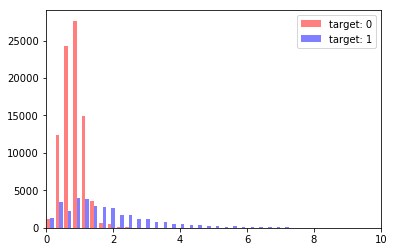

Histogram for std_inter
                  count      mean       std  min   median        max
std_inter (test)  74294  1.448718  0.994011  0.0  1.16619  18.312837


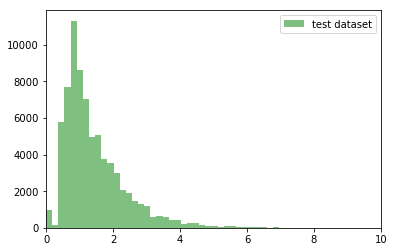

In [40]:
PlotHistByTarget(trains.std_inter, 'std_inter', 0, 10, trains, 'train')
PlotHistByTarget(tests.std_inter, 'std_inter', 0, 10, tests, 'test')

Histogram for mean_inter
                        count      mean       std       min    median   max
mean_inter (target: 0)  85361  1.143695  0.529455  0.083333  1.000000   8.0
mean_inter (target: 1)  34037  1.699274  1.577858  0.000000  1.333333  53.0


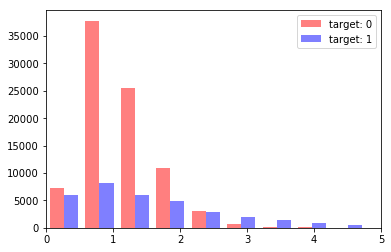

Histogram for mean_inter
                   count      mean       std  min    median   max
mean_inter (test)  74294  1.659146  1.243906  0.0  1.333333  62.0


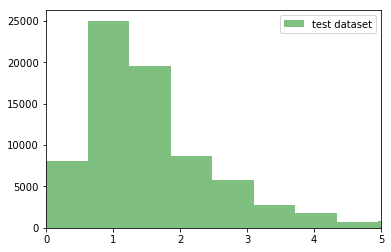

In [41]:
PlotHistByTarget(trains.mean_inter, 'mean_inter', 0, 5, trains, 'train')
PlotHistByTarget(tests.mean_inter, 'mean_inter', 0, 5, tests, 'test')

Histogram for unq_qwords_rate
                             count      mean       std  min  median  max
unq_qwords_rate (target: 0)  85361  0.955034  0.056705  0.5     1.0  1.0
unq_qwords_rate (target: 1)  34037  0.986627  0.037844  0.5     1.0  1.0


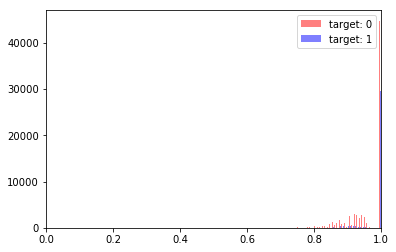

Histogram for unq_qwords_rate
                        count      mean       std       min  median  max
unq_qwords_rate (test)  74294  0.921915  0.146385  0.016611     1.0  1.0


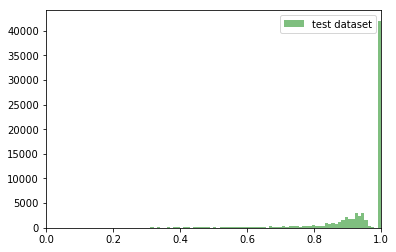

In [186]:
PlotHistByTarget(trains.unq_qwords_rate, 'unq_qwords_rate', 0, 1, trains, 'train')
PlotHistByTarget(tests.unq_qwords_rate, 'unq_qwords_rate', 0, 1, tests, 'test')

Histogram for bigram_intersection
                                 count      mean       std  min  median   max
bigram_intersection (target: 0)  85361  0.187650  0.510228  0.0     0.0  10.0
bigram_intersection (target: 1)  34037  3.620207  3.900680  0.0     3.0  62.0


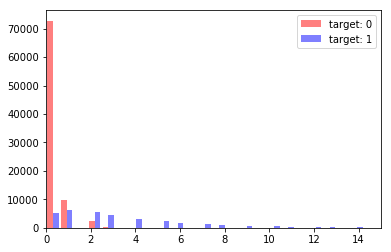

Histogram for bigram_intersection
                            count      mean       std  min  median   max
bigram_intersection (test)  74294  2.394446  3.040992  0.0     1.0  75.0


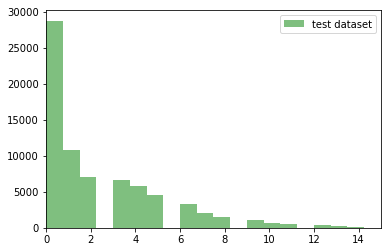

In [70]:
PlotHistByTarget(trains.bigram_intersection, 'bigram_intersection', 0, 15, trains, 'train')
PlotHistByTarget(tests.bigram_intersection, 'bigram_intersection', 0, 15, tests, 'test')

Histogram for trigram_intersection
                                  count      mean      std  min  median   max
trigram_intersection (target: 0)  85361  0.029088  0.20567  0.0     0.0   6.0
trigram_intersection (target: 1)  34037  2.400682  3.68227  0.0     1.0  66.0


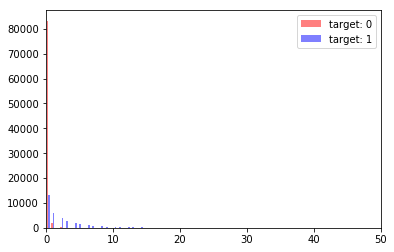

Histogram for trigram_intersection
                             count      mean       std  min  median   max
trigram_intersection (test)  74294  1.547151  2.500417  0.0     0.0  78.0


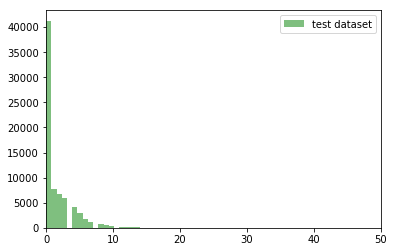

In [69]:
PlotHistByTarget(trains.trigram_intersection, 'trigram_intersection', 0, 50, trains, 'train')
PlotHistByTarget(tests.trigram_intersection, 'trigram_intersection', 0, 50, tests, 'test')

In [218]:
len(tests[tests['unq_qwords_rate']<0.7].question.values)

5417

In [219]:
trains[trains['unq_qwords_rate']<0.7].target.sum()

15.0

In [210]:
for ind in tests[tests['unq_qwords_rate']<0.65].question.index:
    tests.loc[ind, 'prediction'] = 0.0

In [190]:
tests.columns

Index([          'paragraph',        'paragraph_id',            'question',
               'question_id',              'target',               'train',
          'tokens_paragraph',     'tokens_question',     'facts_paragraph',
            'facts_question',
       ...
       (13014, 'prediction'), (13018, 'prediction'), (13026, 'prediction'),
       (13029, 'prediction'), (13040, 'prediction'), (13051, 'prediction'),
       (13059, 'prediction'), (13086, 'prediction'), (13096, 'prediction'),
       (13109, 'prediction')],
      dtype='object', length=810)

In [178]:
tests.columns

Index(['paragraph', 'paragraph_id', 'question', 'question_id', 'target',
       'train', 'tokens_paragraph', 'tokens_question', 'facts_paragraph',
       'facts_question', 'cosine_distance', 'len_paragraph', 'len_question',
       'len_intersection', 'len_intersection_rate', 'terms_paragraph',
       'terms_question', 'terms_intersection', 'terms_intersection_rate',
       'list_ratio', 'list_intersections', 'min_ratio', 'max_ratio',
       'std_ratio', 'mean_ratio', 'num_sentences', 'min_inter', 'max_inter',
       'std_inter', 'mean_inter', 'unq_qwords_rate', 'bigram_intersection',
       'trigram_intersection', 'prediction'],
      dtype='object')

In [173]:
tests.shape

(74294, 36)

In [278]:
trains.loc[25609].paragraph

'Основоположником поэтики считается Аристотель, хотя у него и были предшественники. Зарождение поэтики на греческой почве следует отнести к более раннему времени. Уже в мифических образах девяти муз, как замечает А. Г. Горнфельд, имеются налицо элементы теоретической мысли, различающей специфику разных поэтических жанров. Ряд существенных положений, связанных с областью поэтики, имеется у Платона, непосредственного учителя Аристотеля (относительно деления поэзии на виды, о катарсисе, о подражательной природе поэзии), но он не дал развитой системы поэтики как таковой, оставаясь в плане общефилософской постановки этих вопросов.'

In [281]:
trains.loc[25609].question

'Зарождение поэтики'

In [78]:
columns = ['terms_paragraph',
           'terms_question', 
           'terms_intersection', 
           'terms_intersection_rate',
           'len_paragraph',
           'len_question',
           'len_intersection',
           'min_ratio',
           'max_ratio',
           'std_ratio',
           'mean_ratio',
           'num_sentences',
           #'min_inter',
           'max_inter',
           'std_inter',
           'mean_inter',
           'cosine_distance',
           'bigram_intersection',
           'trigram_intersection',
           'unq_qwords_rate',
           'len_percent',
           'min_len_percent',
           'max_len_percent',
           'std_len_percent',
           'mean_len_percent'
          ]

In [317]:
trains[trains['target']==0.0].shape[0]/trains[trains['target']==1.0].shape[0]

2.5078884743073715

In [318]:
import xgboost as xgb

params ={
        'eta':0.01,
        'n_estimators': 3000,
        #'max_depth': 7,
        'objective': 'binary:logistic',
        'eval_metric': 'auc'
        }

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(trains[columns], trains['target'], test_size=0.2)

do_validation = True

if do_validation:
    dtrain = xgb.DMatrix(X_train[columns], label = y_train)
    dvalid = xgb.DMatrix(X_valid[columns], label = y_valid)
    watchlist = [(dtrain, 'train'), (dvalid, 'train(test)')]
else:
    dtrain = xgb.DMatrix(X_train[columns], label = y_train)
    watchlist = [(dtrain, 'train')]

%time xgb_model = xgb.train(params = params, dtrain = dtrain, evals=watchlist, num_boost_round = params['n_estimators'], verbose_eval=100, early_stopping_rounds=100)

#xgboost.cv(params, dtrain, num_boost_round=10, nfold=3, stratified=False, folds=None, metrics=(), obj=None, 
            #feval=None, maximize=False, early_stopping_rounds=None, fpreproc=None, as_pandas=True, 
            #verbose_eval=None, show_stdv=True, seed=0, callbacks=None)

#%txgb.to_graphviz(bst, num_trees=2)ime xgb_model = xgb.cv(params = params, dtrain = dtrain, num_boost_round = params['n_estimators'], metrics='auc', stratified=True, nfold=5, verbose_eval=100, early_stopping_rounds=100)

dtest = xgb.DMatrix(tests[columns])
#preds = xgb_model.predict(dtest)

tests['prediction'] = xgb_model.predict(dtest,ntree_limit=xgb_model.best_iteration)

[0]	train-auc:0.991731	train(test)-auc:0.990813
Multiple eval metrics have been passed: 'train(test)-auc' will be used for early stopping.

Will train until train(test)-auc hasn't improved in 100 rounds.
[100]	train-auc:0.995523	train(test)-auc:0.994615
[200]	train-auc:0.996345	train(test)-auc:0.995502
[300]	train-auc:0.997022	train(test)-auc:0.996009
[400]	train-auc:0.997507	train(test)-auc:0.996448
[500]	train-auc:0.997831	train(test)-auc:0.996727
[600]	train-auc:0.998053	train(test)-auc:0.996882
[700]	train-auc:0.998204	train(test)-auc:0.997019
[800]	train-auc:0.998345	train(test)-auc:0.997117
[900]	train-auc:0.998454	train(test)-auc:0.997186
[1000]	train-auc:0.998555	train(test)-auc:0.997246
[1100]	train-auc:0.998658	train(test)-auc:0.997285
[1200]	train-auc:0.998743	train(test)-auc:0.997323
[1300]	train-auc:0.998809	train(test)-auc:0.997352
[1400]	train-auc:0.998875	train(test)-auc:0.997375
[1500]	train-auc:0.998935	train(test)-auc:0.997397
[1600]	train-auc:0.998993	train(test)-au

In [319]:
par = []
score = []
for k in xgb_model.get_fscore():
    par.append(k)
    score.append(xgb_model.get_fscore()[k])
res = pd.DataFrame({'variable':par,'split_counts':score})
res['importance'] = res['split_counts']/res['split_counts'].sum()
res.sort_values(by='importance',ascending=False)

,split_counts,variable,importance
18,9208,cosine_distance,0.091240
3,8051,len_percent,0.079775
0,7664,mean_inter,0.075941
15,6446,len_paragraph,0.063872
13,5743,terms_paragraph,0.056906
6,5290,num_sentences,0.052417
7,5084,std_inter,0.050376
16,4853,mean_ratio,0.048087
20,4748,std_ratio,0.047047
5,4660,mean_len_percent,0.046175


In [288]:
print(tests[tests['prediction'] < 0.5].shape[0]/tests[tests['prediction'] > 0.5].shape[0])

1.7267855832048742


In [256]:
def submit(preds,model_name):
    res_frame = pd.DataFrame({"paragraph_id": tests.paragraph_id,
              "question_id": tests.question_id,
              "prediction": preds.values})
    res_frame[['paragraph_id','question_id','prediction']].to_csv("PD_"+model_name+".csv", index=False)

In [270]:
submit(tests['prediction'],'XGB_250917_0a')

In [259]:
print(tests[tests['unq_qwords_rate']<0.5].shape[0])
print(tests[tests['unq_qwords_rate']<0.5].prediction.sum())

2248
1431.38


In [269]:
for ind in tests[tests['unq_qwords_rate']<0.5].question.index:
    tests.loc[ind, 'prediction'] = 0.0

In [268]:
tests.head()

,paragraph,paragraph_id,question,question_id,target,train,tokens_paragraph,tokens_question,facts_paragraph,facts_question,...,"(50315, prediction)","(50318, prediction)","(50359, prediction)","(50447, prediction)","(50482, prediction)","(50517, prediction)","(50552, prediction)","(50583, prediction)","(50617, prediction)","(50658, prediction)"
0,"Передний мозг сильно развит, это самая большая...",1361,В какой мифологии два ворона Хугин и Мунин шеп...,6463,NaN,0,"['передний', 'мозг', 'сильно', 'развитый', 'эт...","['в', 'какой', 'мифология', 'два', 'ворон', 'х...","['часть', 'птица', 'мозг', 'передний мозг', 'с...","['какая мифология', 'два ворон', 'хугин', 'ухо...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Мирмекологи исследуют муравьёв как в лаборатор...,1403,Когда инсайдер покупает или гипотезы чего эвол...,34696,NaN,0,"['мирмеколог', 'исследовать', 'муравей', 'как'...","['когда', 'инсайдер', 'покупать', 'или', 'гипо...","['муравей', 'отбор', 'исследование', 'год', 'у...","['стратегия', 'развитие', 'война', 'устойчивый...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Волновая: свет представляет собой волну в неви...,1435,"Какие предположения, по мнению Ньютона, допуст...",13751,NaN,0,"['волновой', 'свет', 'представлять', 'себя', '...","['какой', 'предположение', 'по', 'мнение', 'нь...","['теория', 'гюйгенс', 'волна', 'невидимый миро...","['натуральный философия', 'какая предположение...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Живые организмы подчиняются началам термодинам...,341,В каких условиях метаболизм поддерживает поряд...,38544,NaN,0,"['живой', 'организм', 'подчиняться', 'начало',...","['в', 'какой', 'условие', 'метаболизм', 'подде...","['система', 'организм', 'живой', 'окружающий с...","['какая условие', 'условие', 'счёт', 'создание...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Файлы нелатинского текста в Юникоде всегда зан...,1317,Каким мелодиям Прокофьева особенно не укладыва...,14589,NaN,0,"['файл', 'нелатинский', 'текст', 'в', 'юникод'...","['какой', 'мелодия', 'прокофьев', 'особенно', ...","['язык', 'символ', 'юникод', 'шрифт', 'файл', ...","['существенный мера', 'какая мелодия', 'язык',...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [123]:
check = pd.read_csv('test_first200_marked.csv').target.values[:200]

In [124]:
check

array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [260]:
preds = tests.prediction.values[:200]

In [261]:
preds

array([  5.39746601e-04,   9.19410363e-02,   4.86343270e-05,
         9.99482512e-01,   1.82405673e-02,   7.85175979e-01,
         9.99315262e-01,   7.49304963e-05,   2.13420138e-01,
         6.37244135e-02,   1.48392729e-02,   5.73512539e-03,
         2.58661730e-05,   5.23806375e-04,   1.00634107e-03,
         9.97949421e-01,   2.52060115e-01,   1.79779739e-03,
         5.41409354e-05,   2.25037569e-03,   9.97090697e-01,
         2.40391865e-03,   2.11716257e-02,   9.58811581e-01,
         9.74810183e-01,   9.65638518e-01,   5.49082085e-03,
         9.97660637e-01,   6.60849959e-02,   1.86454889e-03,
         9.94702756e-01,   2.08542168e-01,   3.98454984e-04,
         9.91267741e-01,   9.38946265e-04,   8.41859379e-04,
         6.41789138e-01,   9.98758793e-01,   1.38387701e-03,
         2.89505553e-02,   9.97363627e-01,   1.95113961e-02,
         9.99524951e-01,   5.81103504e-01,   9.88976419e-01,
         9.99458730e-01,   3.31998861e-04,   1.96685091e-01,
         1.93136348e-03,

In [262]:
tests.unq_qwords_rate[200]

0.65000000000000002

In [263]:
preds_10 = list(map(lambda x: 1.0 if x>=0.5 else 0.0, list(preds)))

In [264]:
print(len(preds))
print(len(check))

200
200


In [265]:
print(len(preds))
print(len(check))

200
200


In [266]:
from sklearn.metrics import accuracy_score, roc_auc_score
roc_auc_score(preds_10,check)

0.63411458333333337

# St XGBoost + 0

In [224]:
import pandas as pd
d = pd.read_csv('xgb_cosine_bl_stas_sol_inversr.csv')

In [225]:
d.head()

,paragraph_id,question_id,prediction
0,1361,6463,1.0
1,1403,34696,1.0
2,1435,13751,1.0
3,341,38544,0.0
4,1317,14589,0.0


In [228]:
d.prediction = list(map(lambda x: float(int(x)^1), list(d.prediction.values)))

In [ ]:
ind = pd.read_csv('unq_qwords_rate_05.csv')

In [229]:
for i in ind.vls.values:
    d.loc[i,'prediction'] = 0.0

,paragraph_id,question_id,prediction
0,1361,6463,0.0
1,1403,34696,0.0
2,1435,13751,0.0
3,341,38544,1.0
4,1317,14589,1.0


In [246]:
d.to_csv('justtry_220917_2230.csv', index=False)

In [232]:
ind.vls.values

array([   53,    74,   166, ..., 74233, 74244, 74270], dtype=int64)

In [239]:
d.prediction[298]

0.0

329.0


In [641]:
def distance(a, b):
    "Calculates the Levenshtein distance between a and b."
    n, m = len(a), len(b)
    if n > m:
        # Make sure n <= m, to use O(min(n,m)) space
        a, b = b, a
        n, m = m, n

    current_row = range(n+1) # Keep current and previous row, not entire matrix
    for i in range(1, m+1):
        previous_row, current_row = current_row, [i]+[0]*n
        for j in range(1,n+1):
            add, delete, change = previous_row[j]+1, current_row[j-1]+1, previous_row[j-1]
            if a[j-1] != b[i-1]:
                change += 1
            current_row[j] = min(add, delete, change)

    return current_row[n]

In [646]:
distance(a,b)

608

In [657]:
for id in range(100):
    a = trains.paragraph[id]
    b = trains.question[id]
    target = trains.target[id]
    print(distance(a,b),target)

608 0.0
540 0.0
450 0.0
500 0.0
718 0.0
587 0.0
775 0.0
900 1.0
700 1.0
788 0.0
947 1.0
524 0.0
591 1.0
1042 0.0
957 0.0
927 1.0
752 0.0
1032 0.0
638 0.0
647 0.0
493 0.0
1351 0.0
565 1.0
496 1.0
748 0.0
647 0.0
583 0.0
652 1.0
763 1.0
858 0.0
604 0.0
390 1.0
598 0.0
425 0.0
574 1.0
831 0.0
594 1.0
661 1.0
1031 0.0
508 1.0
459 1.0
732 0.0
525 0.0
814 0.0
1024 1.0
709 1.0
677 1.0
482 0.0
636 0.0
1045 1.0
752 0.0
868 0.0
566 0.0
439 0.0
659 0.0
878 1.0
840 0.0
696 0.0
754 0.0
467 1.0
826 0.0
863 0.0
867 0.0
816 0.0
977 0.0
495 0.0
547 0.0
952 0.0
1022 0.0
502 0.0
513 0.0
704 0.0
533 1.0
735 0.0
464 1.0
1005 0.0
976 1.0
792 0.0
1046 0.0
1008 0.0
609 0.0
829 0.0
512 0.0
566 1.0
447 0.0
504 0.0
980 0.0
565 1.0
530 0.0
851 0.0
456 1.0
496 0.0
1111 1.0
658 1.0
613 1.0
730 0.0
770 0.0
429 0.0
483 0.0
523 0.0


In [660]:
import gensim
#from gensim.models import word2vec

In [661]:
w2v = gensim.models.KeyedVectors.load_word2vec_format('ruwikiruscorpora_0_300_20.bin',binary=True)

In [666]:
w2v.similarity('cталь_NOUN','стали_VERB')

KeyError: "word 'cталь_NOUN' not in vocabulary"

In [675]:
vocab = list(w2v.vocab.keys())
vocab[:10]

['гессиан_NOUN',
 'rúv_NOUN',
 'да::пешкейра_NOUN',
 'пролистывание_NOUN',
 'рурик_NOUN',
 'телеграфирование_NOUN',
 'рошфор_NOUN',
 'rags_NOUN',
 'растранжиривать_VERB',
 'заходер_NOUN']

In [159]:
s = 'q_train_32324|1.0' 
s[:s.find('|')]

'q_train_32324'

In [676]:
len(vocab)

392339

In [677]:
for i, word in enumerate(vocab):
    if i<10:
        print(word[-4:])

NOUN
NOUN
NOUN
NOUN
NOUN
NOUN
NOUN
NOUN
VERB
NOUN


In [12]:
import pandas as pd
trains, tests = pd.read_csv("train_tokens_facts_number.csv"), pd.read_csv("test_tokens_facts_number.csv")

In [4]:
from gensim.models import Word2Vec
sentences = texts = list(trains['paragraph'])+list(trains['question'])+list(tests['paragraph'])+list(tests['question'])

w2v_trained = Word2Vec(sentences, workers=4, size = 50)


In [5]:
new_model.n_similarity('архозавр','динозавр')

0.95403255499687789

In [684]:
vocab = list(new_model.vocab.keys())

AttributeError: 'Word2Vec' object has no attribute 'vocab'

In [13]:
for name, df in [('train', trains), ('test', tests)]:
    for index, row in tqdm.tqdm_notebook(df.iterrows(), total=df.shape[0], desc="update ids for " + name):
        df.loc[index, 'paragraph_uid'] = 'p_'+name+'_'+str(row.paragraph_id)
        df.loc[index, 'question_uid'] = 'q_'+name+'_'+str(row.question_id)

In [14]:
trains.head()

,paragraph,paragraph_id,question,question_id,target,train,tokens_paragraph,tokens_question,facts_paragraph,facts_question,...,len_paragraph,len_question,len_intersection,len_intersection_rate,terms_paragraph,terms_question,terms_intersection,terms_intersection_rate,paragraph_uid,question_uid
0,"В отличие от рыб, земноводные (амфибии) и прес...",1094,С какого года Русское Царство перешло на летои...,46273,0.0,1,"['в', 'отличие', 'от', 'рыба', 'земноводный', ...","['с', 'какой', 'год', 'русский', 'царство', 'п...","['сердце', 'четырёхкамерный сердце', 'рептилия...","['год', 'русский царство', 'какая год', '1 янв...",...,64,19,4,0.210526,40,12,0,0.000000,p_train_1094,q_train_46273
1,В 1049 году Балдуину V удалось отнять у Герман...,7414,Кто упомянул о его первых разногласиях со Штей...,19164,0.0,1,"['в', '1049', 'год', 'балдуин', 'v', 'удаться'...","['кто', 'упомянуть', 'о', 'он', 'один', 'разно...","['балдуин', 'сын', 'граф', 'фландрий', 'престо...","['подозрительный модернистский наклонность', '...",...,78,29,4,0.137931,34,14,0,0.000000,p_train_7414,q_train_19164
2,Стремление достичь предельных значений ёмкости...,6744,Как называется имеющая мировое значение эпоха ...,39767,0.0,1,"['стремление', 'достигнуть', 'предельный', 'зн...","['как', 'называться', 'иметь', 'мировой', 'зна...","['страница', 'информация', 'блок', 'одиночный ...","['средний веко', 'новый время', 'мировая значе...",...,58,20,5,0.250000,37,12,1,0.083333,p_train_6744,q_train_39767
3,Первый практически пригодный двухтактный газов...,7300,Что усугублялось из-за международного давления...,36318,0.0,1,"['один', 'практически', 'пригодный', 'двухтакт...","['что', 'усугубляться', 'из', 'за', 'междунаро...","['двигатель', 'ленуар', 'электрический искрово...","['международный давление', 'чили', 'торговля',...",...,62,14,3,0.214286,37,7,0,0.000000,p_train_7300,q_train_36318
4,Требуя от художника углубленного изучения изоб...,7077,Какой характер носят пророчества Леонардо да В...,41534,0.0,1,"['требовать', 'от', 'художник', 'углублённый',...","['какой', 'характер', 'носить', 'пророчество',...","['книжка', 'запись', 'своеобразный интимный дн...","['какая характер', 'характер', 'пророчество', ...",...,83,7,4,0.571429,48,5,2,0.400000,p_train_7077,q_train_41534


In [16]:
from collections import Counter

In [23]:
new_dict = dict(zip(list(trains.question_uid), list(trains.paragraph_uid)))

In [30]:
len(new_dict)

38868

In [29]:
sorted(new_dict.items())

[('q_train_0', 'p_train_5380'),
 ('q_train_1', 'p_train_168'),
 ('q_train_100', 'p_train_2833'),
 ('q_train_10000', 'p_train_7048'),
 ('q_train_100001', 'p_train_8313'),
 ('q_train_100002', 'p_train_4355'),
 ('q_train_100005', 'p_train_1646'),
 ('q_train_100017', 'p_train_6193'),
 ('q_train_100019', 'p_train_7300'),
 ('q_train_100024', 'p_train_5690'),
 ('q_train_100028', 'p_train_4064'),
 ('q_train_100030', 'p_train_6177'),
 ('q_train_100031', 'p_train_2856'),
 ('q_train_100037', 'p_train_7373'),
 ('q_train_100040', 'p_train_5380'),
 ('q_train_100042', 'p_train_7083'),
 ('q_train_100043', 'p_train_5985'),
 ('q_train_100044', 'p_train_5116'),
 ('q_train_100048', 'p_train_8371'),
 ('q_train_100049', 'p_train_6754'),
 ('q_train_10005', 'p_train_3037'),
 ('q_train_100050', 'p_train_6166'),
 ('q_train_100053', 'p_train_7380'),
 ('q_train_100054', 'p_train_3559'),
 ('q_train_100058', 'p_train_472'),
 ('q_train_100061', 'p_train_6193'),
 ('q_train_100062', 'p_train_1595'),
 ('q_train_10007',

In [28]:
keylist = new_dict.keys().sort()
#keylist.sort()
#for key in keylist:
#    print "%s: %s" % (key, new_dict[key])

AttributeError: 'dict_keys' object has no attribute 'sort'

In [27]:
keylist

dict_keys(['q_train_88809', 'q_train_48921', 'q_train_90581', 'q_train_9806', 'q_train_59070', 'q_train_30169', 'q_train_85030', 'q_train_65599', 'q_train_92479', 'q_train_65459', 'q_train_14037', 'q_train_60780', 'q_train_42203', 'q_train_96179', 'q_train_2281', 'q_train_15201', 'q_train_60583', 'q_train_48832', 'q_train_98850', 'q_train_71853', 'q_train_62403', 'q_train_77878', 'q_train_88494', 'q_train_71938', 'q_train_70070', 'q_train_39945', 'q_train_54196', 'q_train_7950', 'q_train_97611', 'q_train_81519', 'q_train_27787', 'q_train_42965', 'q_train_87702', 'q_train_6075', 'q_train_50894', 'q_train_63213', 'q_train_79606', 'q_train_92521', 'q_train_73142', 'q_train_3450', 'q_train_44149', 'q_train_57041', 'q_train_13356', 'q_train_92320', 'q_train_9579', 'q_train_15372', 'q_train_84892', 'q_train_53298', 'q_train_32599', 'q_train_26590', 'q_train_80805', 'q_train_71276', 'q_train_100566', 'q_train_31176', 'q_train_13437', 'q_train_47652', 'q_train_78793', 'q_train_66284', 'q_train

In [62]:
df = pd.DataFrame(data=trains[['paragraph_uid','question_uid','target']])
df.head()

,paragraph_uid,question_uid,target
0,p_train_1094,q_train_46273,0.0
1,p_train_7414,q_train_19164,0.0
2,p_train_6744,q_train_39767,0.0
3,p_train_7300,q_train_36318,0.0
4,p_train_7077,q_train_41534,0.0


In [154]:
d = {}
for name, df in [('train', trains), ('test', tests)]:
    for index, row in tqdm.tqdm_notebook(df.iterrows(), total=df.shape[0], desc="build dict for " + name):
        qid = df.loc[index, 'question_uid']
        pid = df.loc[index, 'paragraph_uid']
        target = str(df.loc[index, 'target'])
        par_list = []
        if qid in d.keys():

            d[qid].append(pid+'|'+target)
            #d[qid] = par_list
        else:
            par_list.insert(0, pid+'|'+target)
            d[qid] = par_list

In [ ]:
d['q_test_19164']

In [158]:
set(list(tests.target))

KeyboardInterrupt: 

In [66]:
#def set(self, val_): 
#        i = 0 
#        for val in val_: 
#            if i == 0: 
#                i = 1 
#                key = val 
#            else: 
#                i = 0 
#                self.dict[key] = val 

In [71]:
par_list = list(trains.question)
s = 0

for ind_test, row in tqdm.tqdm_notebook(tests.iterrows(), total=tests.shape[0], desc="calc sum"):
    if tests.loc[ind_test, 'question'] in par_list:
        s += 1
        
print(tests.shape[0]-s)


74281


In [72]:
s

13

In [146]:
def split_tt(train, columns, test_size):
    train_sort = train.sort_values(['paragraph_id'])
    
    train_len =  int((1-test_size)*len(set(list(train_sort.paragraph_id))))
    valid_len = int(test_size*len(set(list(train_sort.paragraph_id))))

    M = list(set(list(train_sort.paragraph_id)))[train_len]
    
    print(train_len, valid_len, M)
    
    X_train = train_sort[train_sort.paragraph_id<=train_len]
    X_valid = train_sort[train_sort.paragraph_id>train_len]
    y_train = train_sort.target[train_sort.paragraph_id<=train_len]
    y_valid = train_sort.target[train_sort.paragraph_id>train_len]
    
    del X_train['target']
    del X_valid['target']
    
    print(train_sort.shape)
    print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)
    
    return X_train, X_valid, y_train, y_valid

In [147]:
X_train, X_valid, y_train, y_valid = split_tt(trains, columns, 0.2)

7262 1815 7262
(119398, 21)
(94764, 20) (24634, 20) (94764,) (24634,)


In [148]:
list(set(list(trains.paragraph_id)))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [150]:
for pid in list(X_valid.paragraph_id):
    tmp = []
    if pid in list(X_train.paragraph_id):
        tmp.append(pid)

In [153]:
if len(tmp) != 0:
    print(tmp, 'Failed!')
else:
    print('Success!')

Success!


In [116]:
X_train[X_train.paragraph_id == 7300]

,paragraph,paragraph_id,question,question_id,train,tokens_paragraph,tokens_question,facts_paragraph,facts_question,cosine_distance,len_paragraph,len_question,len_intersection,len_intersection_rate,terms_paragraph,terms_question,terms_intersection,terms_intersection_rate,paragraph_uid,question_uid
105893,Первый практически пригодный двухтактный газов...,7300,В каком году Павел III передал Парму и Пиаченцу,45413,1,"['один', 'практически', 'пригодный', 'двухтакт...","['в', 'какой', 'год', 'павел', 'iii', 'передат...","['двигатель', 'ленуар', 'электрический искрово...","['какая год', 'пиаченец', 'парма', 'павел', 'г...",0.989074,62,9,3,0.333333,37,5,1,0.200000,p_train_7300,q_train_45413
99224,Первый практически пригодный двухтактный газов...,7300,"В какой период был объединены теория мутации, ...",87710,1,"['один', 'практически', 'пригодный', 'двухтакт...","['в', 'какой', 'период', 'быть', 'объединить',...","['двигатель', 'ленуар', 'электрический искрово...","['теория', 'один теория', 'менделеевский насле...",0.981839,62,13,4,0.307692,37,9,0,0.000000,p_train_7300,q_train_87710
105713,Первый практически пригодный двухтактный газов...,7300,Фамилия немецкого историка и филолога объедини...,54677,1,"['один', 'практически', 'пригодный', 'двухтакт...","['фамилия', 'немецкий', 'историк', 'и', 'филол...","['двигатель', 'ленуар', 'электрический искрово...","['язык', 'семитский язык', 'немецкий историк',...",0.988905,62,17,3,0.176471,37,14,1,0.071429,p_train_7300,q_train_54677
39869,Первый практически пригодный двухтактный газов...,7300,В каком году американский изобретатель и предп...,50126,1,"['один', 'практически', 'пригодный', 'двухтакт...","['в', 'какой', 'год', 'американский', 'изобрет...","['двигатель', 'ленуар', 'электрический искрово...","['гитара fender precision bass', 'fender preci...",0.993333,62,15,3,0.200000,37,12,1,0.083333,p_train_7300,q_train_50126
61523,Первый практически пригодный двухтактный газов...,7300,В каком году был опубликован первый сборник ст...,35261,1,"['один', 'практически', 'пригодный', 'двухтакт...","['в', 'какой', 'год', 'быть', 'опубликовать', ...","['двигатель', 'ленуар', 'электрический искрово...","['один сборник', 'какая год', 'сборник', 'мике...",0.979664,62,10,4,0.400000,37,5,1,0.200000,p_train_7300,q_train_35261
51306,Первый практически пригодный двухтактный газов...,7300,В каких номинациях Валерий Леонтьев практическ...,42056,1,"['один', 'практически', 'пригодный', 'двухтакт...","['в', 'какой', 'номинация', 'валерий', 'леонть...","['двигатель', 'ленуар', 'электрический искрово...","['какая номинация', '2001 год', 'победа', 'ном...",0.962652,62,14,4,0.285714,37,7,1,0.142857,p_train_7300,q_train_42056
73607,Первый практически пригодный двухтактный газов...,7300,В случае какого воздушного судна имеет место б...,17347,1,"['один', 'практически', 'пригодный', 'двухтакт...","['в', 'случай', 'какой', 'воздушный', 'судный'...","['двигатель', 'ленуар', 'электрический искрово...","['авиационный происшествие', 'случай', 'происш...",0.982415,62,21,4,0.190476,37,9,0,0.000000,p_train_7300,q_train_17347
26031,Первый практически пригодный двухтактный газов...,7300,В каком году в СССР вернулись к написанию коне...,28580,1,"['один', 'практически', 'пригодный', 'двухтакт...","['в', 'какой', 'год', 'в', 'ссср', 'вернуться'...","['двигатель', 'ленуар', 'электрический искрово...","['конечный буква', 'какая год', 'ссср', 'напис...",0.985271,62,9,2,0.222222,37,6,1,0.166667,p_train_7300,q_train_28580
51290,Первый практически пригодный двухтактный газов...,7300,В каком году журнал Rolling Stone поставил Боу...,42299,1,"['один', 'практически', 'пригодный', 'двухтакт...","['в', 'какой', 'год', 'журнал', 'rolling', 'st...","['двигатель', 'ленуар', 'электрический искрово...","['журнал rolling stone', '100 великий исполнит...",0.985459,62,20,3,0.150000,37,16,1,0.062500,p_train_7300,q_train_42299
30458,Первый практически пригодный двухтактный газов...,7300,Когда Фишер стал появляться в СМИ с довольно р...,77737,1,"['один', 'практ

In [121]:
max(list(X_train.paragraph_id))

7300

In [128]:
set(list(X_valid.paragraph_id))

{8192,
 8193,
 8194,
 8195,
 8196,
 8197,
 8198,
 8199,
 8200,
 8201,
 8202,
 8203,
 8204,
 8205,
 8206,
 8207,
 8208,
 8209,
 8210,
 8211,
 8212,
 8213,
 8214,
 8215,
 8216,
 8217,
 8218,
 8219,
 8220,
 8221,
 8222,
 8223,
 8224,
 8225,
 8226,
 8227,
 8228,
 8229,
 8230,
 8231,
 8232,
 8233,
 8234,
 8235,
 8236,
 8237,
 8238,
 8239,
 8240,
 8241,
 8242,
 8243,
 8244,
 8245,
 8246,
 8247,
 8248,
 8249,
 8250,
 8251,
 8252,
 8253,
 8254,
 8255,
 8256,
 8257,
 8258,
 8259,
 8260,
 8261,
 8262,
 8263,
 8264,
 8265,
 8266,
 8267,
 8268,
 8269,
 8270,
 8271,
 8272,
 8273,
 8274,
 8275,
 8276,
 8277,
 8278,
 8279,
 8280,
 8281,
 8282,
 8283,
 8284,
 8285,
 8286,
 8287,
 8288,
 8289,
 8290,
 8291,
 8292,
 8293,
 8294,
 8295,
 8296,
 8297,
 8298,
 8299,
 8300,
 8301,
 8302,
 8303,
 8304,
 8305,
 8306,
 8307,
 8308,
 8309,
 8310,
 8311,
 8312,
 8313,
 8314,
 8315,
 8316,
 8317,
 8318,
 8319,
 8320,
 8321,
 8322,
 8323,
 8324,
 8325,
 8326,
 8327,
 8328,
 8329,
 8330,
 8331,
 8332,
 8333,
 8334,